In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

In [2]:
data = np.load("processed_data.npz")

In [3]:
np.savez("sepsis_starting_states.npz", sepsis_starting_states = data['x_valid'])

In [4]:
data.files

['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']

In [5]:
data['x_train'].shape

(153582, 47)

In [6]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [7]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [8]:
valid_matrix = get_padded_matrix( data['x_valid'],  data['y_valid'])

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_matrix.shape[2]-1)
])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                19600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                5934      
Total params: 32,062
Trainable params: 32,062
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
os.remove("sepsis_states.h5py")

try:
    model.load_weights("sepsis_states.h5py")
    print("Loaded saved model :)")
except OSError:
    print("No saved model. Training from scratch.")
    tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed{}".format(time()))
    model.fit(train_matrix, data['y_train'], validation_data=(valid_matrix, data['y_valid']), epochs=10, callbacks=[tensorboard])
    model.save_weights("sepsis_states.h5py")
    
    
    

No saved model. Training from scratch.
Train on 153582 samples, validate on 19527 samples
Epoch 1/10
153582/153582 [==============================] - 55s 356us/step - loss: 0.1773 - val_loss: 0.1207
Epoch 2/10
153582/153582 [==============================] - 55s 357us/step - loss: 0.1392 - val_loss: 0.1165
Epoch 3/10
153582/153582 [==============================] - 59s 386us/step - loss: 0.1370 - val_loss: 0.1161
Epoch 4/10
153582/153582 [==============================] - 55s 356us/step - loss: 0.1360 - val_loss: 0.1147
Epoch 5/10
153582/153582 [==============================] - 57s 374us/step - loss: 0.1354 - val_loss: 0.1139
Epoch 6/10
153582/153582 [==============================] - 65s 426us/step - loss: 0.1349 - val_loss: 0.1140
Epoch 7/10
153582/153582 [==============================] - 61s 397us/step - loss: 0.1346 - val_loss: 0.1157
Epoch 8/10
153582/153582 [==============================] - 55s 357us/step - loss: 0.1343 - val_loss: 0.1142
Epoch 9/10
153582/153582 [============

In [14]:
model.save('sepsis_states.model')

In [15]:
valid_predicted = model.predict(valid_matrix)

In [16]:
train_predicted = model.predict(train_matrix)

In [17]:
columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']

In [18]:
valid_predicted[0:11,columns.index('HeartRate')]

array([-0.739196  , -0.5450218 , -0.53526014, -0.52386504, -0.51899636,
       -0.54569846, -0.17479046, -0.14162192, -0.13982552, -0.30801123,
       -0.8056447 ], dtype=float32)

In [19]:
sns.set(style="white")

def plot(column, mode="valid", prediction=valid_predicted):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][0:20,columns.index(column)], label="truth")
    plt.plot(prediction[0:20,columns.index(column)], label="predicted")
    plt.legend(["truth", "predicted"])
    plt.title(column + " " + mode)
    plt.show()

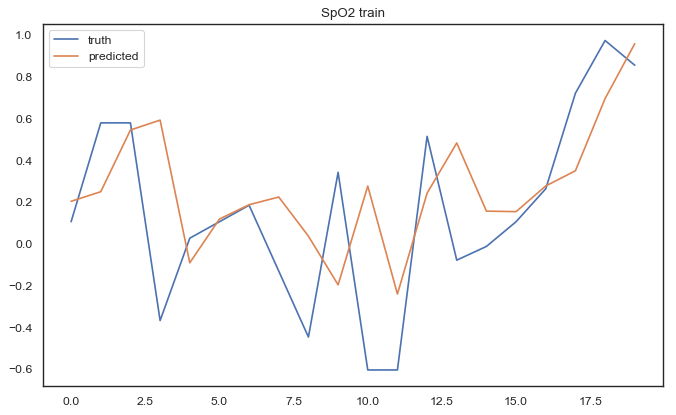

In [20]:
plot("SpO2", "train", train_predicted)

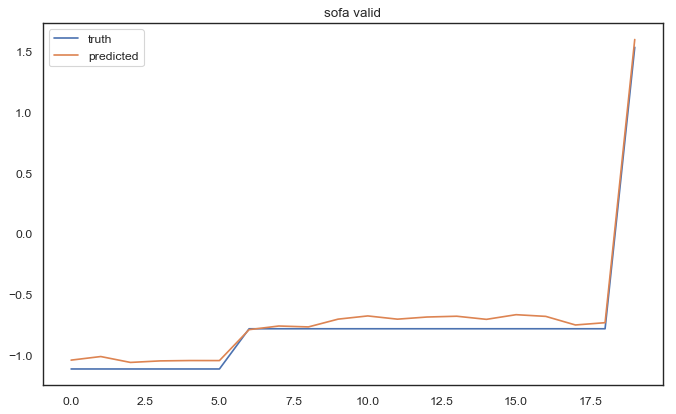

In [21]:
plot("sofa")

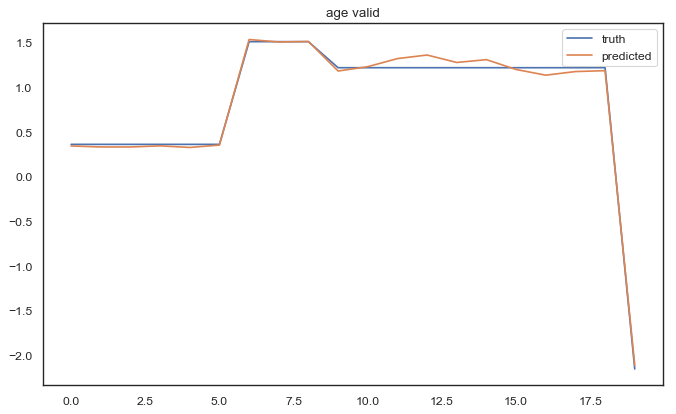

In [22]:
plot("age")

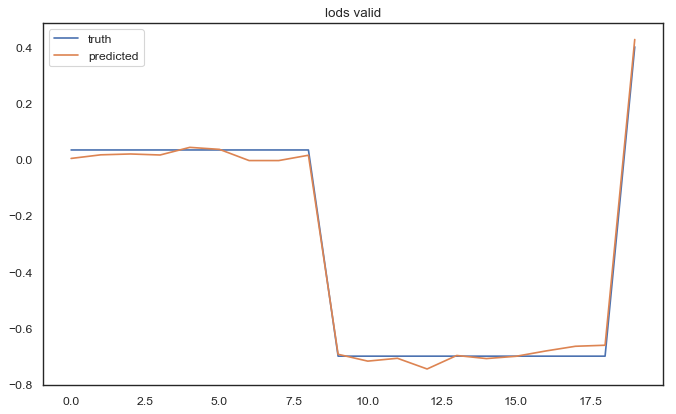

In [23]:
plot("lods")

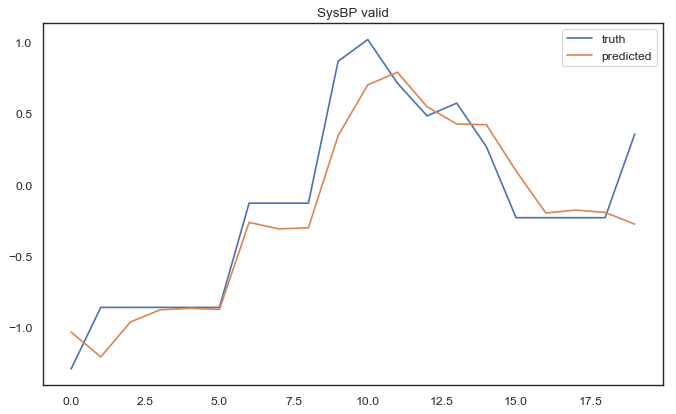

In [24]:
plot("SysBP")

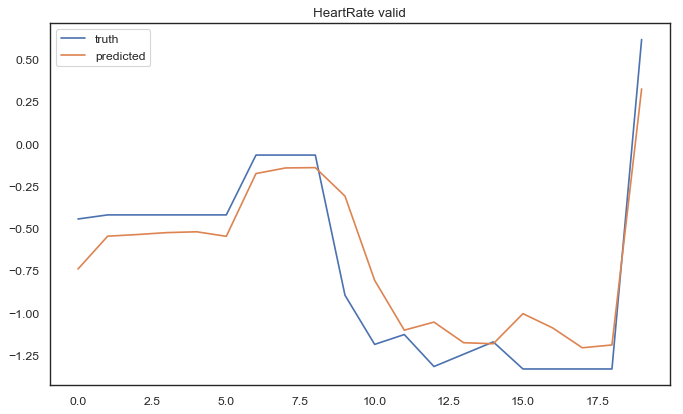

In [25]:
plot("HeartRate")

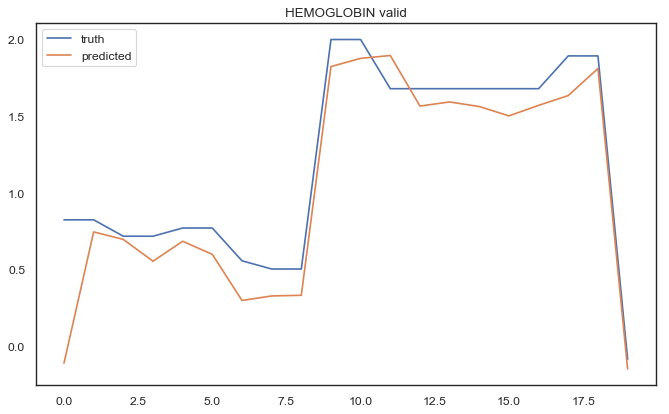

In [26]:
plot("HEMOGLOBIN")

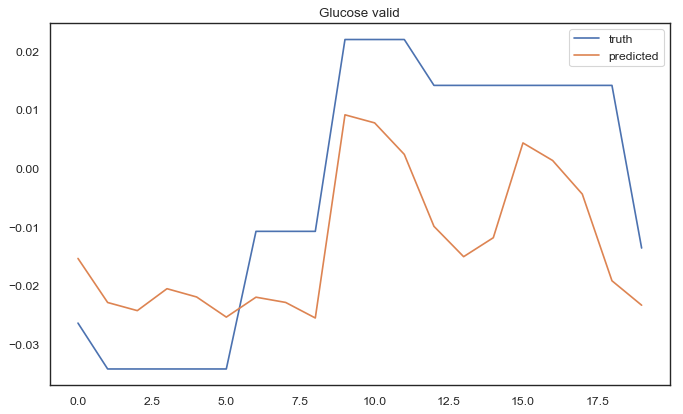

In [27]:
plot("Glucose")

In [126]:
model.save('sepsis_states.json')